# Tracking a Panda: When Smoothers Fail
#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025


## Part I - Forward–Backward Exponential smoothing

### 1. random-walk process and noise; forward exponential smoothing and running mean

The same as in `tracking_panda assignment` random-walk process and noise, same forward exponential smoothing and running mean

Parameters:
- $n$ points $= 300$
- $\sigma_w^2 = 28^2$
- $\sigma_\eta^2 = 97^2$
- Initial position $X_1 = 10$ m

In [115]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_random_walk(n_points, sigma_w_sq, sigma_eta_sq, init_pos=10):
    wi = np.random.normal(0, np.sqrt(sigma_w_sq), n_points)
    Xi = np.zeros(n_points)
    Xi[0] = init_pos
    for i in range(1, n_points):
        Xi[i] = Xi[i-1] + wi[i]
    eta = np.random.normal(0, np.sqrt(sigma_eta_sq), n_points)
    z = Xi + eta

    return Xi, z

def calc_optimal_alpha(sigma_w_sq, sigma_eta_sq):
    chi = sigma_w_sq / sigma_eta_sq
    alpha = (-chi + np.sqrt(chi**2 + 4*chi)) / 2
    return alpha

def exponential_smoothing(z, alpha):
    s = np.zeros_like(z)
    s[0] = z[0]
    for i in range(1, len(z)):
        s[i] = alpha * z[i] + (1 - alpha) * s[i-1]
    return s


### Apply exponential smoothing and compare with true trajectory

As same as in the tracking_panda experiment

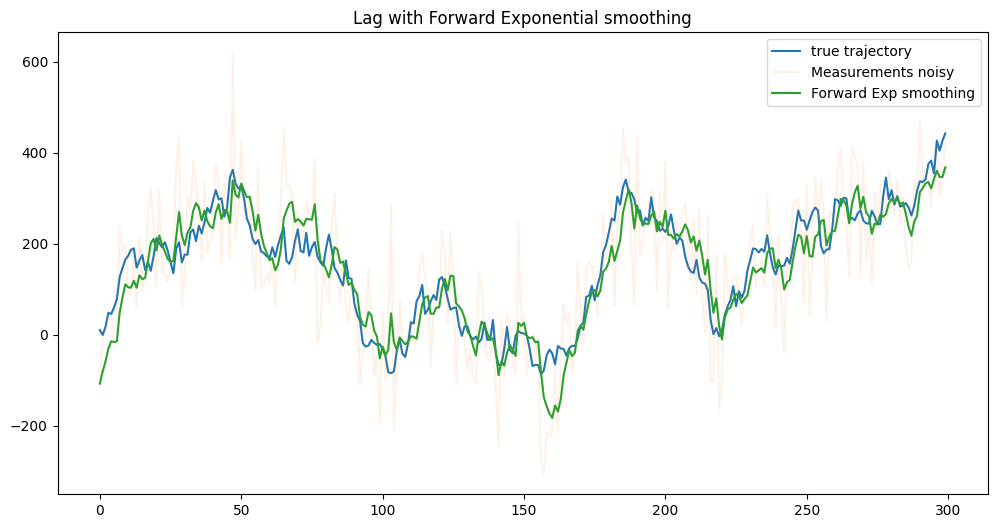

In [133]:
sigma_w2_shaky = 28**2
sigma_eta2_shaky = 97**2

alpha_shaky = calc_optimal_alpha(sigma_w2_shaky, sigma_eta2_shaky)
Xi, z = simulate_random_walk(300, sigma_w2_shaky, sigma_eta2_shaky, init_pos=10)
es_forward = exponential_smoothing(z, alpha_shaky)

plt.figure(figsize=(12,6))
plt.plot(Xi, label='true trajectory')
plt.plot(z, alpha=0.1, label='Measurements noisy')
plt.plot(es_forward, label='Forward Exp smoothing')
plt.legend()
plt.title('Lag with Forward Exponential smoothing')
plt.show()

### 2. Backward exponential smoothing

Apply backward exponential smoothing to forward exponential smoothing curve to further reduce measurement errors

In [134]:
def forward_backward_exponential_smoothing(z, alpha):
    forward = exponential_smoothing(z, alpha)
    backward = exponential_smoothing(forward[::-1], alpha)[::-1]
    return backward

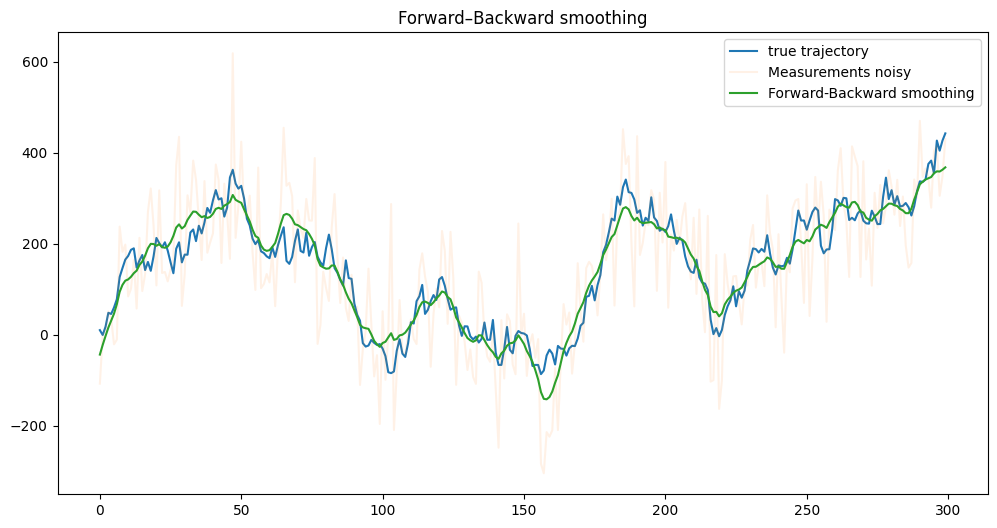

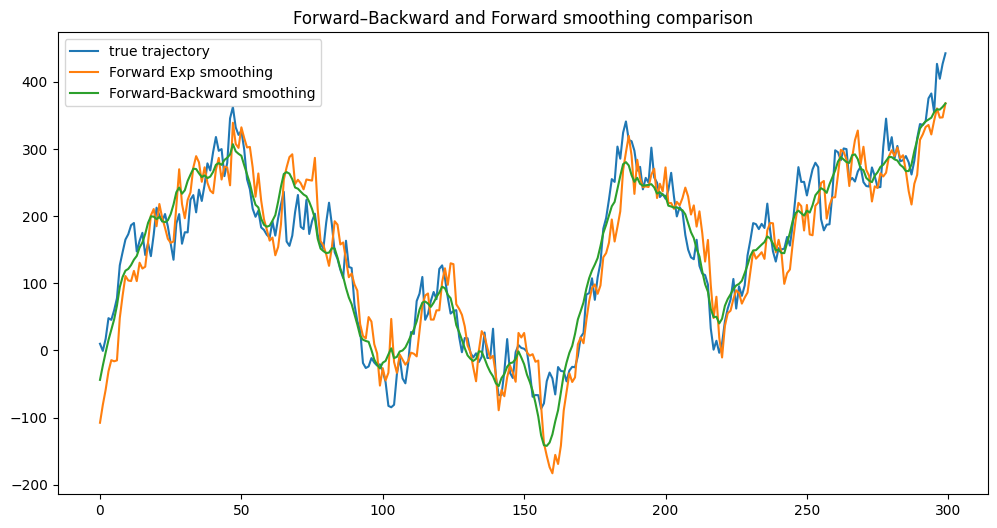

In [135]:
es_fb = forward_backward_exponential_smoothing(z, alpha_shaky)

plt.figure(figsize=(12,6))
plt.plot(Xi, label='true trajectory')
plt.plot(z, alpha=0.1, label='Measurements noisy')
plt.plot(es_fb, label='Forward-Backward smoothing')
plt.legend()
plt.title('Forward–Backward smoothing')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(Xi, label='true trajectory')
plt.plot(es_forward, label='Forward Exp smoothing')
plt.plot(es_fb, label='Forward-Backward smoothing')
plt.legend()
plt.title('Forward–Backward and Forward smoothing comparison')
plt.show()

### 3. Compare methods visually

In [119]:
def running_mean(data, window_size):
    if len(data) < window_size:
        return []

    N = len(data)
    smoothed = np.zeros(N)

    for i in range(N):
        smoothed[i] = np.mean(data[max(0, i-6):min(N, i+7)])

    return smoothed

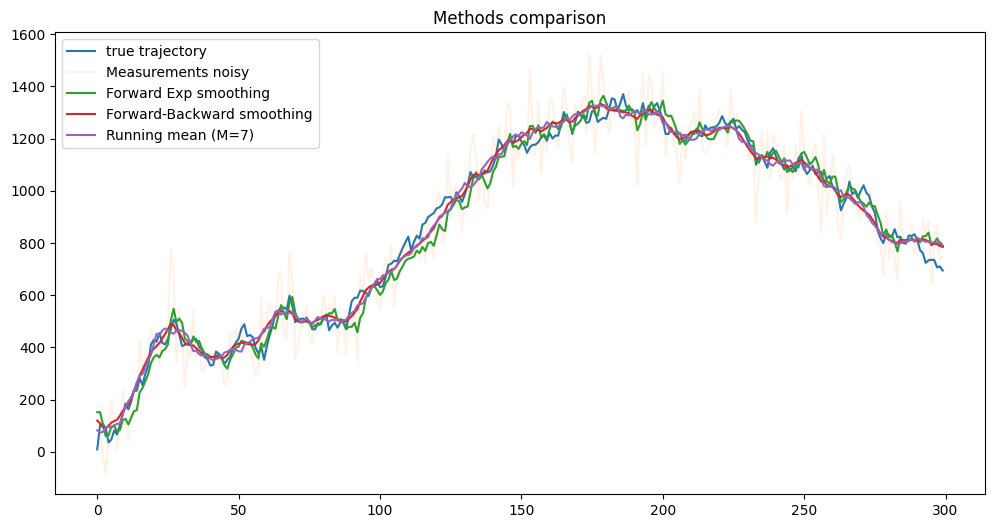

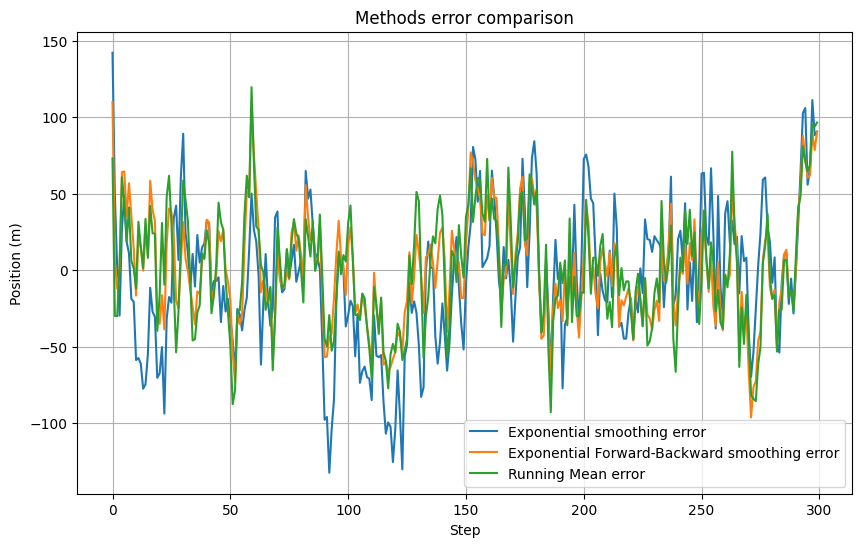

In [120]:
M = round((2 - alpha_shaky) / alpha_shaky)
rm = running_mean(z, M)

plt.figure(figsize=(12,6))
plt.plot(Xi, label='true trajectory')
plt.plot(z, alpha=0.1, label='Measurements noisy')
plt.plot(es_forward, label='Forward Exp smoothing')
plt.plot(es_fb, label='Forward-Backward smoothing')
plt.plot(rm, label=f'Running mean (M={M})')
plt.legend()
plt.title('Methods comparison')
plt.show()


plt.figure(figsize=(10,6))
plt.plot(es_forward - Xi, label='Exponential smoothing error')
plt.plot(es_fb - Xi, label='Exponential Forward-Backward smoothing error')
plt.plot(rm - Xi, label='Running Mean error')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('Methods error comparison')
plt.legend()
plt.grid()
plt.show()

## Part II. A. "Sun-nap stroll": Slow Motion, Heavy Noise

### 1. Simulate panda motion with slowly changing velocity and compare running mean and exponential smoothing.

In [121]:
def simulate_sun_nap(n_points=300, T=0.1, sigma_a2=10, sigma_eta2=500):
    a = np.random.normal(0, np.sqrt(sigma_a2), n_points)
    X = np.zeros(n_points)
    V = np.zeros(n_points)
    X[0], V[0] = 5, 0
    for i in range(1, n_points):
        X[i] = X[i-1] + V[i-1]*T + 0.5*a[i-1]*T**2
        V[i] = V[i-1] + a[i-1]*T
    eta = np.random.normal(0, np.sqrt(sigma_eta2), n_points)
    z = X + eta
    return X, z

X_true, z = simulate_sun_nap()

### 2. Experiments

Empirically determine the optimal window size $𝑀$ for the running mean and the smoothing coefficient for forward exponential smoothing to achieve the best estimation of the panda’s motion using the measurements $𝑧_𝑖$.

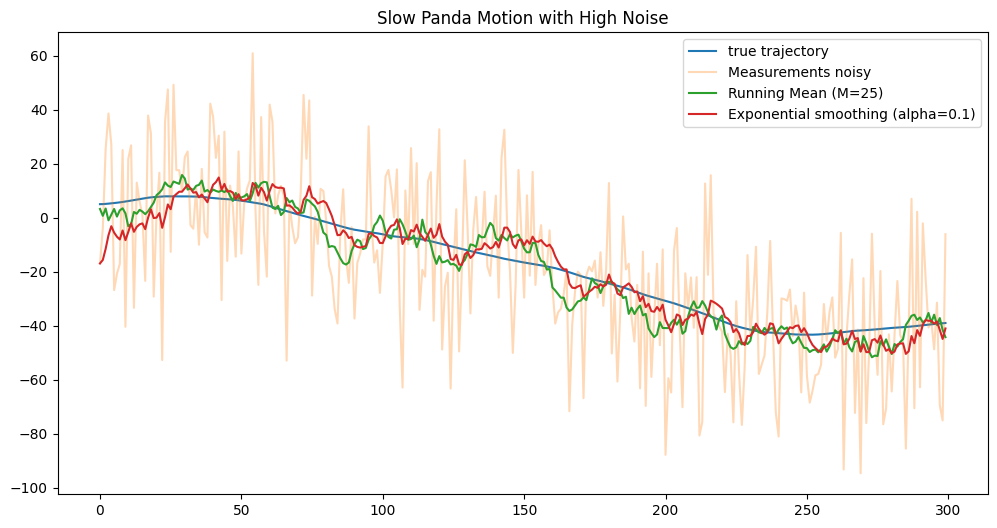

In [122]:
M_opt = 25  # Empirically chosen window size
rm_est = running_mean(z, M_opt)

alpha_test = 0.1  # Empirically chosen smoothing coefficient
es_est = exponential_smoothing(z, alpha_test)

plt.figure(figsize=(12,6))
plt.plot(X_true, label='true trajectory')
plt.plot(z, alpha=0.3, label='Measurements noisy')
plt.plot(rm_est, label=f'Running Mean (M={M_opt})')
plt.plot(es_est, label=f'Exponential smoothing (alpha={alpha_test})')
plt.legend()
plt.title('Slow Panda Motion with High Noise')
plt.show()

### 3. Most effective smoothing method based on deviation and variability indicators. Conclusion

# Part II. B. Cyclic Motion in Rolling Bamboo Hills

### 4. Generate a cyclic trajectory $𝑋_𝑖$. Generate measurements $𝑧_𝑖$ of the panda’s cyclic motion $𝑋_𝑖$

In [123]:
# Trajectory parameters
n_points = 200
T = 32
sigma_w2 = 0.08**2
sigma_eta2 = 0.05
M = 13 

def generate_cyclic_motion(T, n_points):
    omega = 2 * np.pi / T

    A = np.zeros(n_points)
    X = np.zeros(n_points)
    A[0] = 1.0

    for i in range(1, n_points):
        wi = np.random.normal(0, np.sqrt(sigma_w2))
        A[i] = A[i-1] + wi
        X[i] = A[i] * np.sin(omega * i + 3)

    eta = np.random.normal(0, np.sqrt(sigma_eta2), n_points)
    z = X + eta

    return X, z

X_cyclic, z_cyclic = generate_cyclic_motion(T, n_points)

### 5. Apply running mean with a window size of $𝑀 = 13$ to the measurements

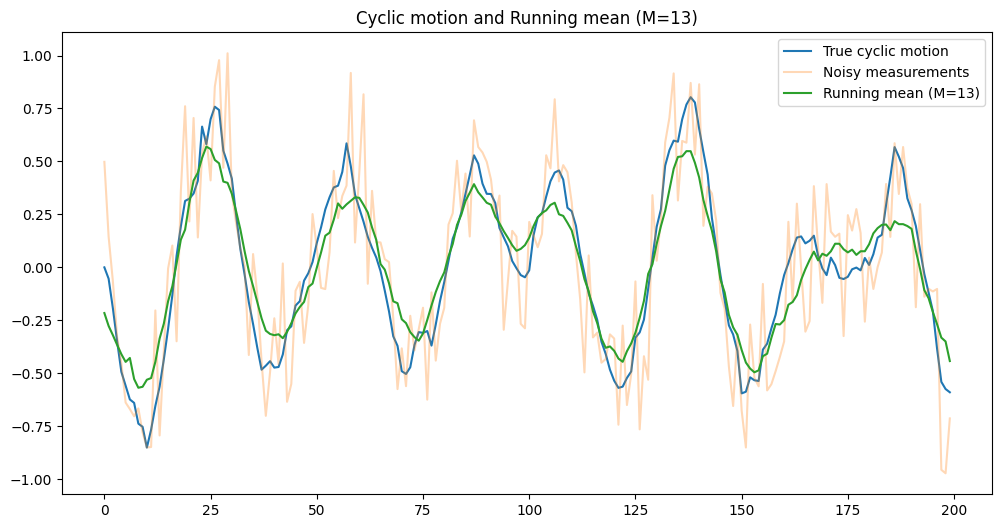

In [124]:
rm = running_mean(z_cyclic, M)

plt.figure(figsize=(12,6))
plt.plot(X_cyclic, label='True cyclic motion')
plt.plot(z_cyclic, alpha=0.3, label='Noisy measurements')
plt.plot(rm, label=f'Running mean (M={M})')
plt.legend()
plt.title('Cyclic motion and Running mean (M=13)')
plt.show()

#### Experiments with running mean window size

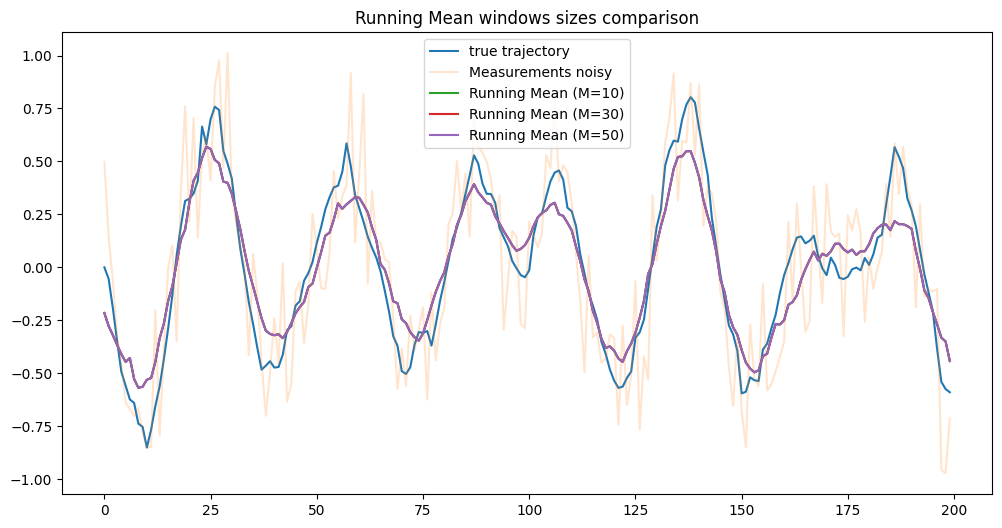

In [125]:
plt.figure(figsize=(12,6))
plt.plot(X_cyclic, label='true trajectory')
plt.plot(z_cyclic, alpha=0.2, label='Measurements noisy')
for M in [10, 30, 50]:
    rm = running_mean(z_cyclic, M)
    plt.plot(rm, label=f'Running Mean (M={M})')
plt.legend()
plt.title('Running Mean windows sizes comparison')
plt.show()

### 6. Oscillation Period Analysis

Test how the running mean with window size 13 affects signals with different periods.

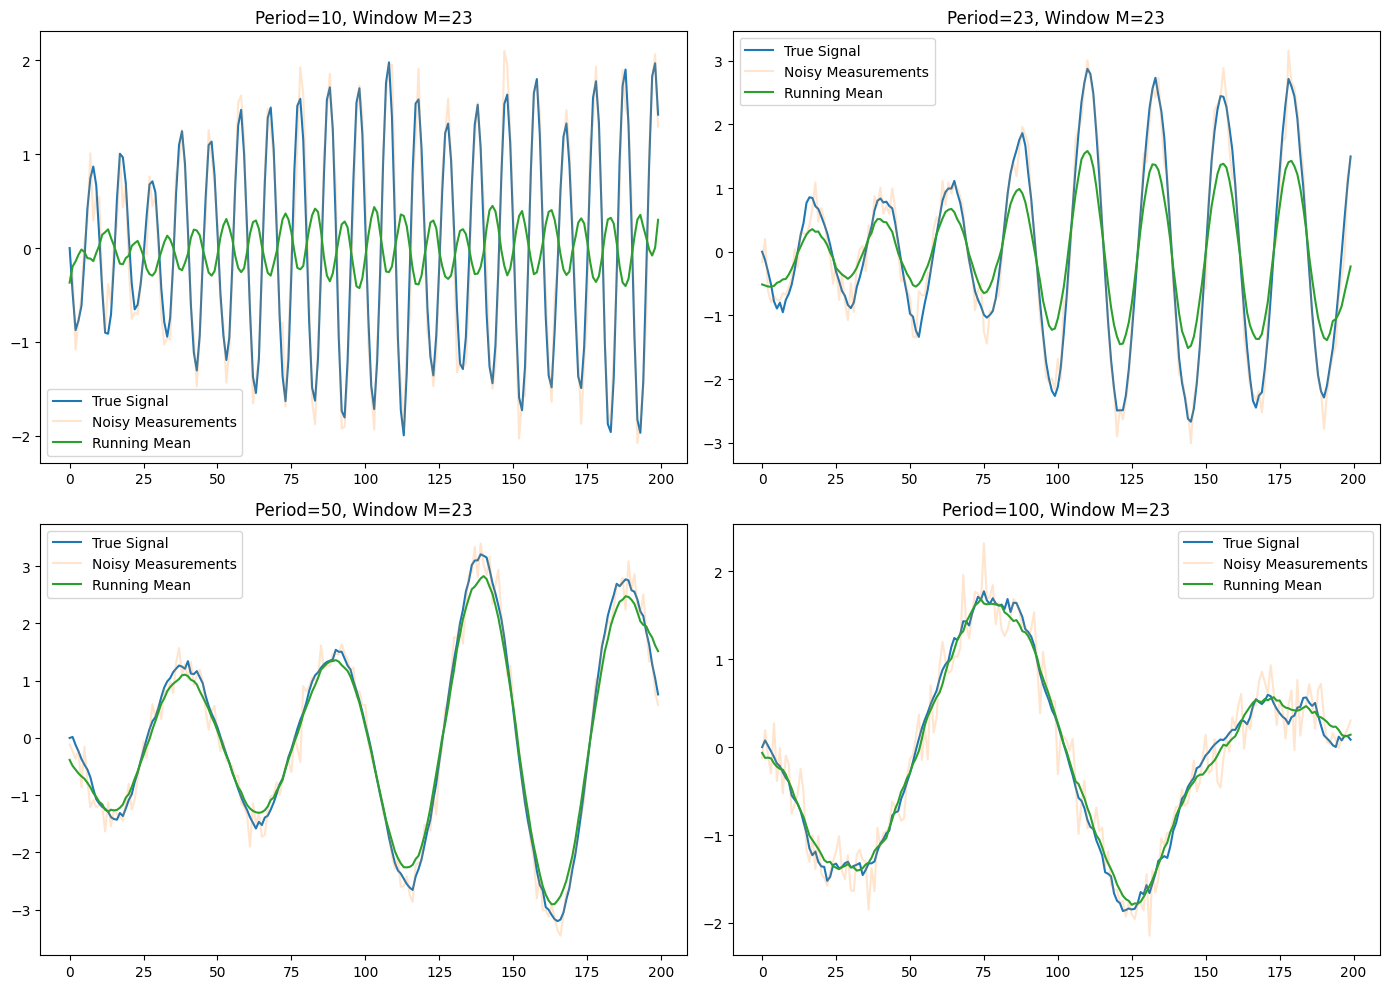

In [130]:
M = 23
periods = [10, 23, 50, 100]
plt.figure(figsize=(14,10))
for idx, period in enumerate(periods, 1):
    X, z = generate_cyclic_motion(T=period, n_points=200)
    rm = running_mean(z, M)
    plt.subplot(2,2,idx)
    plt.plot(X, label='True Signal')
    plt.plot(z, alpha=0.2, label='Noisy Measurements')
    plt.plot(rm, label='Running Mean')
    plt.title(f'Period={period}, Window M={M}')
    plt.legend()

plt.tight_layout()
plt.show()

### Conclusions
- When the period is much smaller than the window size, the running mean causes inverse oscillations due to signal aliasing.
- When the period is close to the window size, running mean can eliminate oscillations.
- When the period is larger than the window size, the running mean smooths noise but retains oscillation shape.
- Therefore, the running mean window size relative to the oscillation period critically affects the output.

#### Additional. Experiments with Forward-Backward Exponential smoothing alpha coefficient

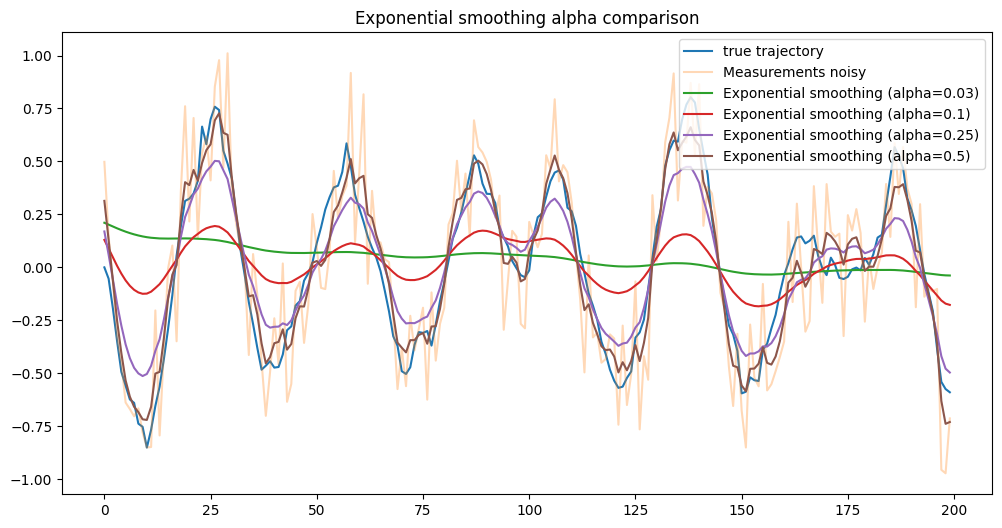

In [132]:
plt.figure(figsize=(12,6))
plt.plot(X_cyclic, label='true trajectory')
plt.plot(z_cyclic, alpha=0.3, label='Measurements noisy')
for alpha in [0.03, 0.1, 0.25, 0.5]:
    es_est = forward_backward_exponential_smoothing(z_cyclic, alpha)
    plt.plot(es_est, label=f'Exponential smoothing (alpha={alpha})')
plt.legend()
plt.title('Exponential smoothing alpha comparison')
plt.show()